# Spotify EDA and Baseline Model
Seth Billiau, William Drew, Sarah Lucioni


## EDA

We will explore the Spotify data using the Spotify API through the Spotipy library. We aim to find out what data we are working with and how we can predict a playlist from minimal user input.

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 25)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
import random

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import pickle

## Clean Data

First, we need to clean our data. To use the Spotify API, having just the URI is much more useful then having extra characters appended to the URI. For this reason, we will clean these extra strings from our data. 

In [3]:
# remove "spotify:track:", "spotify:artist:", and "spotify:album:" from uri
def clean_data(i):
    df = pd.read_csv('Songs/songs' + str(i) + '.csv')
    df["track_uri"] = df["track_uri"].str[14:]
    df["artist_uri"] = df["artist_uri"].str[15:]
    df["album_uri"] = df["album_uri"].str[14:]
    return df

df = clean_data(0)

In [4]:
# Look to see if data is cleaned
df.head()

,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name
0,0,0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook
1,0,1,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,26dSoYclwsYLMAKD3tpOr4,Toxic,0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone
2,0,2,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,6vWDO969PvNqNYHIOW5v0m,Crazy In Love,25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit)
3,0,3,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,31TPClRtHm23RisEBtV3X7,Rock Your Body,6QPkyl04rXwTGlGlcYaRoW,267266,Justified
4,0,4,Shaggy,1lzr43nnXAijIGYnCT8M8H,5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot


## Access Spotify API

Now, we will access the Spotify API. We need to set our API keys and set up authentication with the API.

In [5]:
# https://stackoverflow.com/questions/30557409/spotify-api-post-call-response-415
# https://stackoverflow.com/questions/30557409/spotify-api-post-call-response-415
def initiate_api():    
    client_id = "9cd3dd2ea2cf492ca28ab0247a79d781"
    client_secret = "11c972ad002843e9be5ecc31f022dd6e"
    grant_type = 'client_credentials'
    body_params = {'grant_type' : grant_type}
    url = 'https://accounts.spotify.com/api/token'
    response = requests.post(url, data=body_params, auth = (client_id, client_secret)) 
    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
    return spotipy.Spotify(client_credentials_manager=client_credentials_manager)
sp = initiate_api()

Now, let's check to see if we can access the audio features of a song via the track_uri.

In [6]:
sp.audio_features(["0UaMYEvWZi0ZqiDOoHU3YI"])

[{'danceability': 0.904,
  'energy': 0.813,
  'key': 4,
  'loudness': -7.105,
  'mode': 0,
  'speechiness': 0.121,
  'acousticness': 0.0311,
  'instrumentalness': 0.00697,
  'liveness': 0.0471,
  'valence': 0.81,
  'tempo': 125.461,
  'type': 'audio_features',
  'id': '0UaMYEvWZi0ZqiDOoHU3YI',
  'uri': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI',
  'track_href': 'https://api.spotify.com/v1/tracks/0UaMYEvWZi0ZqiDOoHU3YI',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0UaMYEvWZi0ZqiDOoHU3YI',
  'duration_ms': 226864,
  'time_signature': 4}]

## Add helpful functions

Let's add some helpful functions to explore the data. This includes extracting the songs via track_uri from each playlist and find the mean of the audio_features for a playlist.

In [7]:
def songs_in_playlist(df, pid):
    '''
    input: dataframe and playlist ID
    returns: list of all songs on playlist by track_uri 
    '''
    playlist = np.where(df.pid == pid)
    return list(df.iloc[playlist]["track_uri"])

def playlist_means(tracks):
    '''
    input: list of tracks on a playlist (can be generated from songs_in_playlist())
    returns: statistics for audio features of playlist  
    '''
    num = len(tracks)
    # We can only pass 100 tracks at a time
    if num <= 100:
        p = pd.DataFrame.from_records(list(filter(None, sp.audio_features(tracks))))
    else:
        start = 0
        end = 100
        p = pd.DataFrame.from_records(sp.audio_features(tracks[start:end]))
        for i in range(int(num / 100) - 1):
            start = end
            diff = num - end
            if diff > 100:
                end += 100
            else:
                end += diff
            
            new_p = pd.DataFrame.from_records(sp.audio_features(tracks[start:end]))
            p = p.append(new_p) 
    return p.describe()

In [8]:
# Testing the functionality of the above functions
tracks = songs_in_playlist(df, 42)
playlist_means(tracks)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.608800,0.754630,5.730000,-5.381940,0.85000,0.069557,0.163935,0.000284,0.196471,0.615364,129.866700,209552.380000,3.990000
std,0.113241,0.147631,3.659373,1.791111,0.35887,0.059405,0.188315,0.001633,0.150850,0.213495,30.332655,27850.898239,0.173787
min,0.307000,0.268000,0.000000,-14.373000,0.00000,0.026200,0.001120,0.000000,0.023800,0.096400,74.142000,142212.000000,3.000000
25%,0.531500,0.683000,2.000000,-6.070250,1.00000,0.037125,0.029175,0.000000,0.089425,0.469500,104.739500,190183.500000,4.000000
50%,0.593500,0.780000,6.000000,-5.258000,1.00000,0.047950,0.072500,0.000000,0.148000,0.642000,126.556000,207799.500000,4.000000
75%,0.705750,0.853750,9.000000,-4.083000,1.00000,0.076875,0.240250,0.000002,0.288750,0.780000,152.486000,225495.000000,4.000000
max,0.862000,0.965000,11.000000,-2.457000,1.00000,0.438000,0.868000,0.015000,0.962000,0.964000,205.903000,298641.000000,5.000000


## Visualization

The function below will iterate through our data and collect useful information which we will later visualize to add to our EDA. We only need to run this cell once because we will save the data in pickle files so that we don't have to run through all of the data again and again. Furthermore, we are visualizing on all of the data because we are not certain how we will split our data into train and test.

In [9]:
RAN = True
if not RAN:
    # Playlist length num of songs
    # Playlist length duration
    playlist_lengths = []
    playlist_durations = []

    song_counter = {}
    song_to_uri = {}

    artist_counter = {}
    artist_to_uri = {}

    album_counter = {}
    album_to_uri = {}
    for i in range(1000):
        df = clean_data(i)
        for j in range(1000):
            playlist = np.where(df.pid == j)
            tracks = list(df.iloc[playlist]["track_uri"])
            duration = sum(list(df.iloc[playlist]["duration_ms"]))

            playlist_lengths.append(len(tracks))
            playlist_durations.append(duration)

            # Find most popular songs
            tracks_name = list(df.iloc[playlist]["track_name"])
            for index, track in enumerate(tracks_name):
                if track in song_counter:
                    song_counter[track] += 1
                else:
                    song_counter[track] = 1
                    # Create a dictionary between song names and their URI
                    song_to_uri[track] = tracks[index]

            # Find most popular artist
            artist_name = list(df.iloc[playlist]["artist_name"])
            artists = list(df.iloc[playlist]["artist_uri"])
            for index, artist in enumerate(artist_name):
                if artist in artist_counter:
                    artist_counter[artist] += 1
                else:
                    artist_counter[artist] = 1
                    # Create a dictionary between artist names and their URI
                    artist_to_uri[artist] = artists[index]

            # Find most popular album
            album_name = list(df.iloc[playlist]["album_name"])
            albums = list(df.iloc[playlist]["album_uri"])
            for index, album in enumerate(album_name):
                if album in album_counter:
                    album_counter[album] += 1
                else:
                    album_counter[album] = 1
                    # Create a dictionary between artist names and their URI
                    album_to_uri[album] = albums[index]

    # RAN ONCE, DON'T RUN AGAIN. LOAD THE PICKLE FILES INSTEAD

In [10]:
if not RAN:
    # Sort song, artist, album by most occurrences before pickling
    sorted_songs = sorted(song_counter.items(), key=lambda x: x[1], reverse=True)
    sorted_artist = sorted(artist_counter.items(), key=lambda x: x[1], reverse=True)
    sorted_album = sorted(album_counter.items(), key=lambda x: x[1], reverse=True)

In [11]:
# Write playlist_lengths and playlist_durations to a pickle so we don't have to run everything again
# https://pythontips.com/2013/08/02/what-is-pickle-in-python/
def pickle_obj(filename, obj):
    fileObj = open(filename, 'wb')
    pickle.dump(obj, fileObj)
    fileObj.close()
    
# Write objects to pickle files
# pickle_obj('playlist_lengths', playlist_lengths)

# pickle_obj('playlist_durations', playlist_durations)

# pickle_obj('song_counter', song_counter)

# pickle_obj('sorted_songs', sorted_songs)

# pickle_obj('song_to_uri', song_to_uri)

# pickle_obj('artist_counter', artist_counter)

# pickle_obj('sorted_artist', sorted_artist)

# pickle_obj('artist_to_uri', artist_to_uri)

# pickle_obj('album_counter', album_counter)

# pickle_obj('sorted_album', sorted_album)

# pickle_obj('album_to_uri', album_to_uri)

# Uncomment if you want to read the pickle
fileObj = open('sarah/pickle_files/playlist_lengths', 'rb')
playlist_lengths = pickle.load(fileObj)

fileObj = open('sarah/pickle_files/playlist_durations', 'rb')
playlist_durations = pickle.load(fileObj)

fileObj = open('sarah/pickle_files/song_counter', 'rb')
song_counter = pickle.load(fileObj)

fileObj = open('sarah/pickle_files/sorted_songs', 'rb')
sorted_songs = pickle.load(fileObj)

fileObj = open('sarah/pickle_files/song_to_uri', 'rb')
song_to_uri = pickle.load(fileObj)

fileObj = open('sarah/pickle_files/artist_counter', 'rb')
artist_counter = pickle.load(fileObj)

fileObj = open('sarah/pickle_files/sorted_artist', 'rb')
sorted_artist = pickle.load(fileObj)

fileObj = open('sarah/pickle_files/artist_to_uri', 'rb')
artist_to_uri = pickle.load(fileObj)

fileObj = open('sarah/pickle_files/album_counter', 'rb')
album_counter = pickle.load(fileObj)

fileObj = open('sarah/pickle_files/sorted_album', 'rb')
sorted_album = pickle.load(fileObj)

fileObj = open('sarah/pickle_files/album_to_uri', 'rb')
album_to_uri = pickle.load(fileObj)

Time to plot the above data!

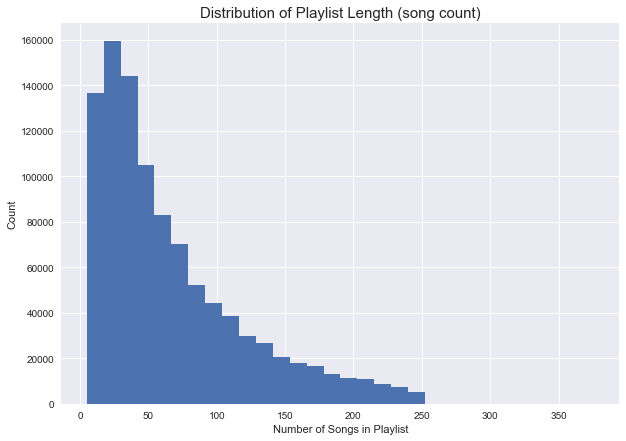

In [12]:
plt.figure(figsize=(10,7))
plt.hist(playlist_lengths, bins=30)
plt.xlabel("Number of Songs in Playlist")
plt.ylabel("Count")
plt.title("Distribution of Playlist Length (song count)", size=15)
plt.show()

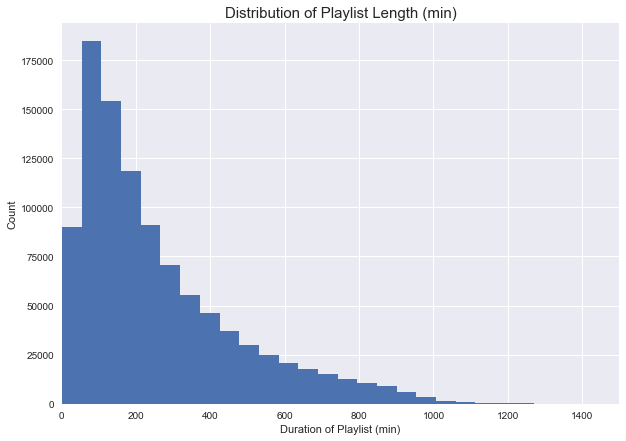

In [13]:
plt.figure(figsize=(10,7))
playlist_durations_min = np.asarray(playlist_durations)/60000
plt.hist(playlist_durations_min, bins=200)
plt.xlim(0,1500)
plt.xlabel("Duration of Playlist (min)")
plt.ylabel("Count")
plt.title("Distribution of Playlist Length (min)", size=15)
plt.show()

In [14]:
def summary_stats(arr):
    print("mean: ", np.mean(arr))
    print("std: ", np.std(arr))
    print("median: ", np.median(arr))
    print("max: ", np.max(arr))
    print("min: ", np.min(arr))
     
print("Playlist song count statistics (songs)")
print("----------------------------")
summary_stats(playlist_lengths)


print("\nPlaylist duration statistics (mins)")
print("----------------------------")
summary_stats(playlist_durations_min)

Playlist song count statistics (songs)
----------------------------
mean:  66.346428
std:  53.66933116446316
median:  49.0
max:  376
min:  5

Playlist duration statistics (mins)
----------------------------
mean:  259.66128071163337
std:  214.27380245241304
median:  190.37396666666666
max:  10584.5632
min:  1.6256333333333333


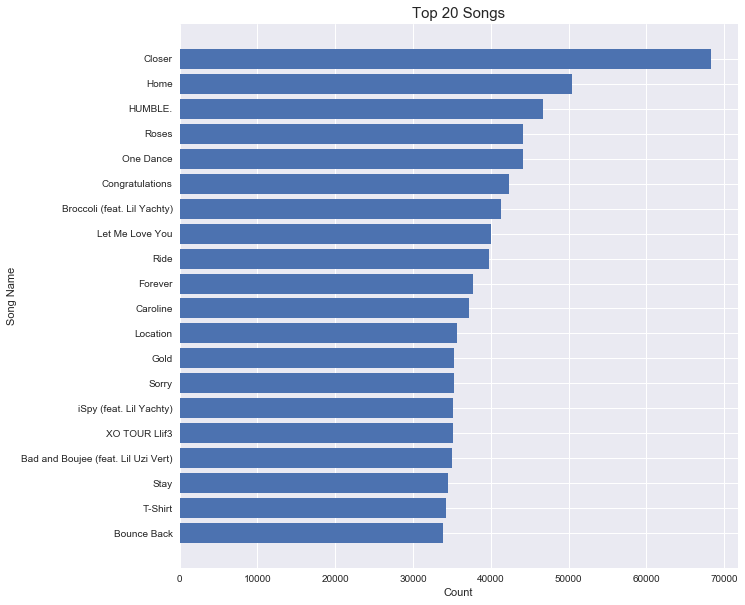

In [15]:
plt.figure(figsize=(10,10))
topSongs = sorted_songs[:20]
topSongs.reverse()
topSongs_names = [x[0] for x in topSongs]
numbered = np.arange(len(topSongs_names))
topSongs_values = [x[1] for x in topSongs]
plt.barh(numbered, topSongs_values, align='center')
plt.yticks(numbered, topSongs_names)
plt.xlabel("Count")
plt.ylabel("Song Name")
plt.title("Top 20 Songs", size=15)
plt.show()

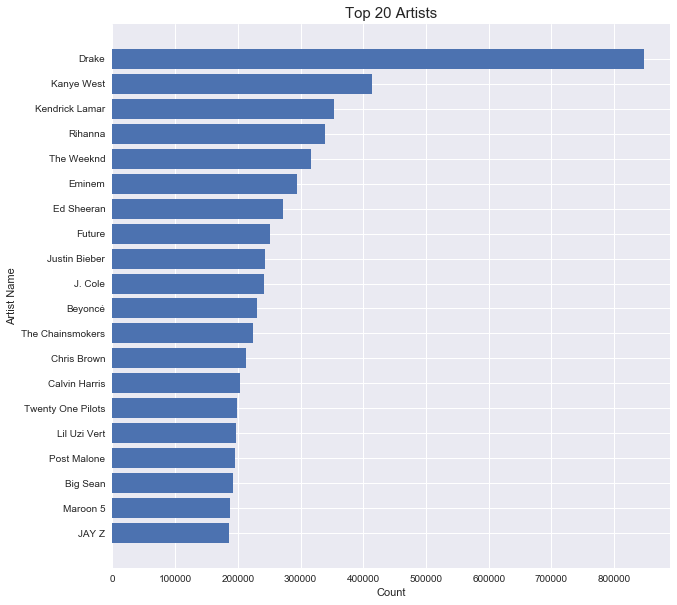

In [16]:
plt.figure(figsize=(10,10))
topArtists = sorted_artist[:20]
topArtists.reverse()
topArtists_names = [x[0] for x in topArtists]
numbered = np.arange(len(topArtists_names))
topArtists_values = [x[1] for x in topArtists]
plt.barh(numbered, topArtists_values, align='center')
plt.yticks(numbered, topArtists_names)
plt.xlabel("Count")
plt.ylabel("Artist Name")
plt.title("Top 20 Artists", size=15)
plt.show()

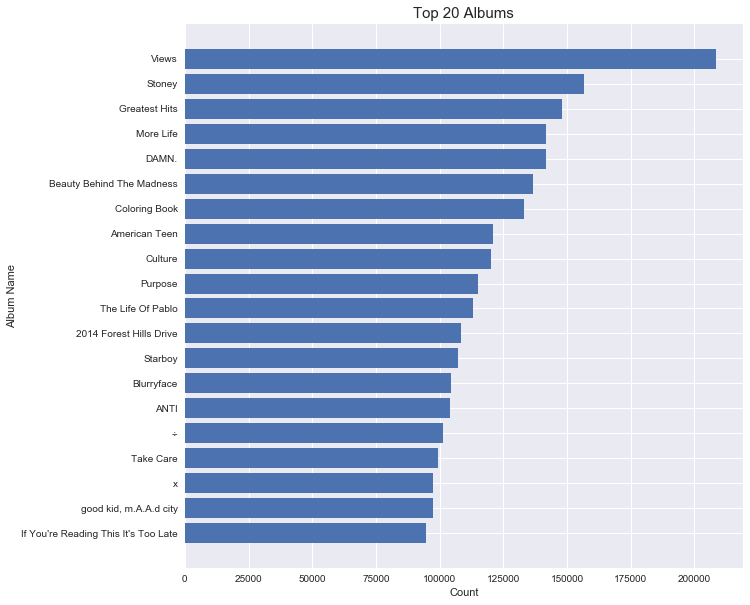

In [17]:
plt.figure(figsize=(10,10))
topAlbums = sorted_album[:20]
topAlbums.reverse()
topAlbums_names = [x[0] for x in topAlbums]
numbered = np.arange(len(topAlbums_names))
topAlbums_values = [x[1] for x in topAlbums]
plt.barh(numbered, topAlbums_values, align='center')
plt.yticks(numbered, topAlbums_names)
plt.xlabel("Count")
plt.ylabel("Album Name")
plt.title("Top 20 Albums", size=15)
plt.show()

Load Compiled 30k playlist .pkl file. Print shape and head. 

In [18]:
songs = pd.read_pickle("william/pickles/songs_30k_dropped.pkl")
print(songs.shape)
songs.head()


(199252, 19)


,index,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
53,1,0.000032,https://api.spotify.com/v1/audio-analysis/1MYY...,0.343,70294,0.975,1MYYt7h6amcrauCOoso3Gx,0.991,1,0.0515,-2.502,0,0.1350,119.883,4,https://api.spotify.com/v1/tracks/1MYYt7h6amcr...,audio_features,spotify:track:1MYYt7h6amcrauCOoso3Gx,0.133
54,2,0.000023,https://api.spotify.com/v1/audio-analysis/3x2m...,0.414,65306,0.959,3x2mJ2bjCIU70NrH49CtYR,0.933,7,0.3680,-4.299,0,0.0378,145.911,4,https://api.spotify.com/v1/tracks/3x2mJ2bjCIU7...,audio_features,spotify:track:3x2mJ2bjCIU70NrH49CtYR,0.589
55,3,0.053400,https://api.spotify.com/v1/audio-analysis/1Pm3...,0.522,108532,0.205,1Pm3fq1SC6lUlNVBGZi3Em,0.235,2,0.0985,-7.986,1,0.0376,103.868,4,https://api.spotify.com/v1/tracks/1Pm3fq1SC6lU...,audio_features,spotify:track:1Pm3fq1SC6lUlNVBGZi3Em,0.353
59,7,0.201000,https://api.spotify.com/v1/audio-analysis/7dkb...,0.493,226000,0.969,7dkbEHIMLoeuG4zXGmzhEH,0.655,2,0.2470,-3.282,0,0.0463,170.581,4,https://api.spotify.com/v1/tracks/7dkbEHIMLoeu...,audio_features,spotify:track:7dkbEHIMLoeuG4zXGmzhEH,0.340
88,36,0.007740,https://api.spotify.com/v1/audio-analysis/0hBb...,0.293,658987,0.787,0hBby0yygBY1u3m6tSpZgC,0.496,5,0.3920,-8.841,1,0.0438,165.307,4,https://api.spotify.com/v1/tracks/0hBby0yygBY1...,audio_features,spotify:track:0hBby0yygBY1u3m6tSpZgC,0.138


Visualize Audio Features normalized

Text(0.5,1,'Distribution of song features in the 200k song dataset')

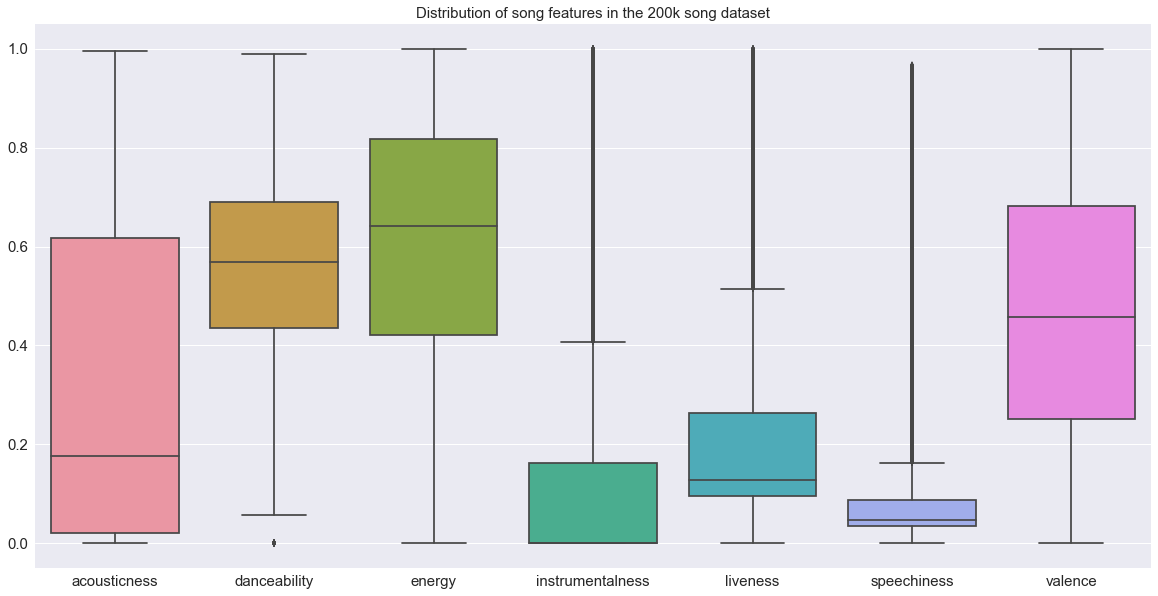

In [19]:
song_features = songs[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness','valence']]
plt.rcParams['figure.figsize']=[20,10]
ax = sns.boxplot(data=song_features)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_title("Distribution of song features in the 200k song dataset", fontsize = 15)

Prepare unnormalized audio features

In [20]:
song_duration = songs['duration_ms']/1000
song_duration = song_duration.reset_index().drop(columns = 'index')
song_tempo = songs['tempo']
song_tempo = song_tempo.reset_index().drop(columns = 'index')
song_loudness = songs['loudness']
song_loudness = song_loudness.reset_index().drop(columns = 'index')

Plot unnormalized audio features

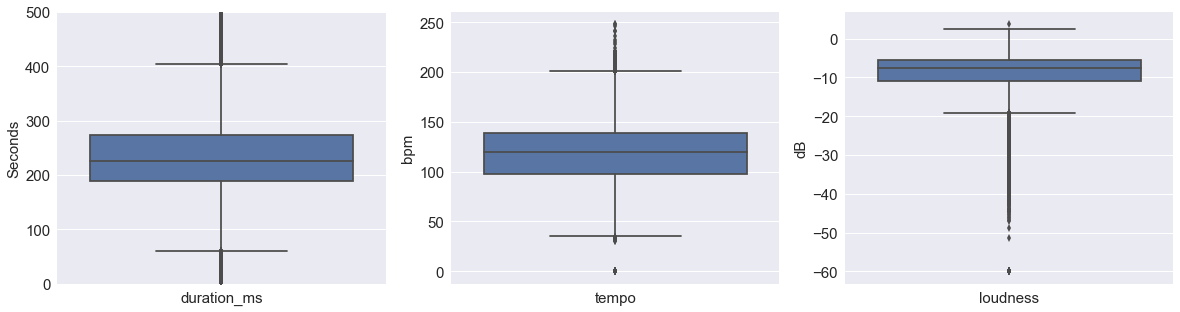

In [21]:
plt.rcParams['figure.figsize']=[20,5]
ax = plt.subplot(131)
ax = sns.boxplot(data=song_duration)
ax.set_ylim(0,500)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_ylabel("Seconds", fontsize = 15)
ax = plt.subplot(132)
ax = sns.boxplot(data=song_tempo)
ax.set_ylabel("bpm", fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax = plt.subplot(133)
ax = sns.boxplot(data=song_loudness)
ax.set_ylabel("dB", fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

Get Summary statistics for songs dataframe.

In [22]:
songs.describe()

,index,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,199252.000000,199252.000000,199252.000000,1.992520e+05,199252.000000,199252.000000,199252.000000,199252.000000,199252.000000,199252.000000,199252.000000,199252.000000,199252.000000,199252.000000
mean,37.650809,0.324306,0.556000,2.441802e+05,0.603160,0.181495,5.251491,0.208895,-8.999104,0.655286,0.088199,120.487872,3.893120,0.470437
std,27.193352,0.340081,0.180091,1.282015e+05,0.256615,0.323783,3.561136,0.188702,5.159350,0.475276,0.107022,29.685628,0.439971,0.263156
min,0.000000,0.000000,0.000000,3.056000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,0.019700,0.436000,1.883528e+05,0.422000,0.000000,2.000000,0.096300,-11.030000,0.000000,0.035100,97.410000,4.000000,0.251000
50%,32.000000,0.176000,0.569000,2.258015e+05,0.642000,0.000207,5.000000,0.128000,-7.659000,1.000000,0.047000,120.025000,4.000000,0.457000
75%,58.000000,0.617000,0.691000,2.742970e+05,0.818000,0.163000,8.000000,0.264000,-5.528000,1.000000,0.086400,138.976250,4.000000,0.682000
max,99.000000,0.996000,0.990000,5.279768e+06,1.000000,1.000000,11.000000,1.000000,3.744000,1.000000,0.967000,247.963000,5.000000,1.000000


# Spotify Cold Start Models

## k-NN and k-Means Clustering Models

Our first set of models are k-Nearest Neighbor based models. These models exhibit a more tailored playlist. Our next set of models are k-Means Clustering based models. These exhibit a more computer selected playlist. By creating both sets of models, we will be able to test "human selection" vs. "computer selection."

We will evaluate each song by it's audio features determined via the Spotify API. The audio features we will use are:

- acousticness
- danceability
- energy
- instrumentalness
- liveness
- speechiness
- tempo

Spotify normalizes all values except tempo. 

The model variations we will explore include: 
- (**distance metric**) euclidean distance vs. cosine similarity
- (**tempo variations**) raw tempo vs. not using tempo  

Reload songs_df and isolate columns that are relevant

In [23]:
songs_df = pd.read_pickle("william/pickles/songs_30k_dropped.pkl")
songs_df.head()
cols = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness", "tempo"]
cols_no_tempo = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness"]
songs_df_w_features = songs_df[cols]
songs_df_no_tempo = songs_df[cols_no_tempo]

## k-NN Models

Our k-NN models will have two variants: metric and tempo. This leads to four k-NN models total. The four models are:

- k-NN using Euclidean distance and tempo
- k-NN using Euclidean distance and no tempo
- k-NN using Cosine Similarity and tempo
- k-NN using Cosine Similarity and no tempo

We decided to only look at raw tempo vs. no tempo values instead of also trying to normalize tempo. We came to this conclusion after testing normalized tempo and saw that the playlists typically consisted of songs with missing audio features. This created a lot of issues while trying to test, so we decided to omit normalization of tempo.

The **knn** function below is our general k-NN model. 

In [24]:
def knn(songs_df, seed_song, n, metric="euclid", tempo=False):
    '''
    inputs:
        songs_df : dataframe of the audio features of all songs 
        seed_song : the uri of the seed song 
        n : length of desired playlist
        metric : string, "dist" or "sim" for euclidean distance or cosine similarity as the distance metric
        tempo : whether or not tempo should be included
    outputs:
        dist : pandas Series with 
    '''
    cols = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness", "tempo"]
    cols_no_tempo = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness"]
    
    seed_song = pd.DataFrame(sp.audio_features(seed_song))

    # Calculate distance using the desired metric
    if metric == "sim":
        if tempo:
            dist = cosine_similarity(np.asarray(songs_df[cols]), np.asarray(seed_song[cols]))
        else:
            dist = cosine_similarity(np.asarray(songs_df[cols_no_tempo]), np.asarray(seed_song[cols_no_tempo]))
            
        dist = pd.Series(dist.reshape(-1,))
        topn_dist = dist.sort_values(ascending=False)[0:n]
    else:
        if tempo:
            dist = euclidean_distances(np.asarray(songs_df[cols]), np.asarray(seed_song[cols]))
        else:
            dist = euclidean_distances(np.asarray(songs_df[cols_no_tempo]), np.asarray(seed_song[cols_no_tempo]))
            
        dist = pd.Series(dist.reshape(-1,))
        topn_dist = dist.sort_values()[0:n]
    
    topn = topn_dist.index
    return topn

In [25]:
def playlist_printer(ids, songs_df, kmeans=False):
    '''
    print out the playlist from song indexes and return the audio features of the playlist
    
    inputs:
        ids : list of song indexes in df
        songs_df : dataframe containing songs
    output: 
        playlist_features : dataframe of the audio features of the playlist
    '''
    cols = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness", "tempo"]
    playlist_features = pd.DataFrame(columns = cols)
    
    for i in ids:
        if kmeans:
            track_uri = songs_df.loc[i].id
        else:
            track_uri = songs_df.iloc[i].id
        track = sp.track(track_uri)
        print(track['name'])
        print('by')
        for artist in track['artists']:
            print(artist['name'])
        print('-----------------------------------')
        
        playlist_features = playlist_features.append(pd.DataFrame(sp.audio_features(track_uri))[cols])
        
    return playlist_features

Below, we use the above **knn** function to define each of our four k-NN models.

In [26]:
'''
run the model stated by the name

inputs: 
    songs_df : dataframe containing songs
    seed_song : the uri of the seed song
    n : length of desired playlist
output:
    mean audio features of the playlist
'''

def knn_euclid_tempo(songs_df, seed_song, n):
    topn_ids = knn(songs_df, seed_song, n, metric="euclid", tempo=True)
    pf = playlist_printer(topn_ids, songs_df)
    return pf.describe().loc["mean"]

def knn_euclid_no_tempo(songs_df, seed_song, n):
    topn_ids = knn(songs_df, seed_song, n, metric="euclid", tempo=False)
    pf = playlist_printer(topn_ids, songs_df)
    return pf.describe().loc["mean"]

def knn_sim_tempo(songs_df, seed_song, n):
    topn_ids = knn(songs_df, seed_song, n, metric="sim", tempo=True)
    pf = playlist_printer(topn_ids, songs_df)
    return pf.describe().loc["mean"]

def knn_sim_no_tempo(songs_df, seed_song, n):
    topn_ids = knn(songs_df, seed_song, n, metric="sim", tempo=False)
    pf = playlist_printer(topn_ids, songs_df)
    return pf.describe().loc["mean"]

In [27]:
def run_all_knn(songs_df, seed_song, n):
    '''
    run all of the k-NN models, print each model type and playlist, return a dataframe of the 
    audio feature means of each playlist created by each model
    
    inputs:
        songs_df : dataframe containing songs
        seed_song : the uri of the seed song
        n : length of desired playlist
    output:
        means_df : dataframe of the audio feature means of each playlist created by each model
    '''
    print("k-NN, euclidean distance, tempo included")
    print("****************************************")
    mean_knn_euclid_tempo = knn_euclid_tempo(songs_df, seed_song, n)
    
    print("\nk-NN, euclidean distance, tempo NOT included")
    print("****************************************")
    mean_knn_euclid_no_tempo = knn_euclid_no_tempo(songs_df, seed_song, n)
    
    
    print("\nk-NN, cosine similarity, tempo included")
    print("****************************************")
    mean_knn_sim_tempo = knn_sim_tempo(songs_df, seed_song, n)
    
    print("\nk-NN, cosine similarity, tempo NOT included")
    print("****************************************")
    mean_knn_sim_no_tempo = knn_sim_no_tempo(songs_df, seed_song, n)
    
    
    means_df = pd.concat([mean_knn_euclid_tempo, mean_knn_euclid_no_tempo, 
                          mean_knn_sim_tempo, mean_knn_sim_no_tempo], 
                         axis=1)
    means_df = means_df.transpose()
    means_df = means_df.append(pd.DataFrame(sp.audio_features(seed_song))[["acousticness", "danceability", 
                                                                           "energy", "instrumentalness", 
                                                                           "liveness", "speechiness", "tempo"]])
    means_df.index = ["k-NN/euclid/tempo", "k-NN/euclid/no tempo", "k-NN/sim/tempo", "k-NN/sim/no tempo", "seed song"]
    means_df = means_df.fillna(0)
    return means_df

Feel free to change the song and generate your own unique playlists.

In [37]:
# Charlie Puth, Senorita = "0TK2YIli7K1leLovkQiNik"
# Yo-Yo Ma, Cello Suite No. 1 in G Major = "61dYvvfIRtIDFuqZypPAta"
# Mariah Carey, All I Want for Christmas is You = "1bCQIvugIRkL0yLG5cvQcZ"
# Michael Bublé, It's Beginning to Look a lot Like Christmas = "5a1iz510sv2W9Dt1MvFd5R"
seed_song = "0TK2YIli7K1leLovkQiNik"
length = 5
run_all_knn(songs_df, seed_song, length)

k-NN, euclidean distance, tempo included
****************************************
Beautiful Love - Radio Version
by
Angelika Dusk
Playmen
-----------------------------------
The Distance
by
San Cisco
-----------------------------------
Let's Reggae All Night
by
CSS
-----------------------------------
Stay Down
by
Mary J. Blige
-----------------------------------
Stacey's Mom (Karaoke Version) - Originally Performed By Fountains of Wayne
by
Karaoke Legends
-----------------------------------

k-NN, euclidean distance, tempo NOT included
****************************************
Nena
by
Miguel Bosé
-----------------------------------
Come Home
by
Antix
-----------------------------------
Turn It Around
by
neutral.
-----------------------------------
Tus Ojos
by
Belanova
-----------------------------------
Till the Next One Comes
by
Solship
Futuristic
-----------------------------------

k-NN, cosine similarity, tempo included
****************************************
Carla
by
Jamiroquai
--

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo
k-NN/euclid/tempo,0.010961,0.7476,0.5362,0.001458,0.09950,0.03844,116.9870
k-NN/euclid/no tempo,0.032260,0.7556,0.5434,0.002894,0.09458,0.03406,105.4358
k-NN/sim/tempo,0.032680,0.7558,0.5448,0.002408,0.09660,0.03602,117.2114
k-NN/sim/no tempo,0.039260,0.7378,0.5258,0.000316,0.09284,0.03160,114.4000
seed song,0.037000,0.7590,0.5400,0.000000,0.09450,0.02870,116.9470


## k-Means Clustering

k-Means Clustering is an unsupervised machine learning algorithm which aims to split *n* observations (songs) into *k* clusters based on the nearest mean. We will have two k-Means Clustering models: one using tempo, a second which omits tempo.

In [29]:
def kmeans(k, songs_df, seed_song, n, tempo=False, kmeans=None):
    '''
    Given a seed song (track_uri), predict a playlist of n song indexes
    
    inputs:
        k : number of clusters
        songs_df : k-means clustering model
        seed_song : the uri of the seed song 
        n : number of songs in playlist
        tempo : whether or not tempo should be included
    outputs:
        playlist_ids : list of n song indexes in the dataframe which is the playlist
        kmeans : the kmeans model that was fit on the songs_df
    '''
    # If a kmeans model already exists, do not refit a new model
    if tempo:
        cols = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness", "tempo"]
        songs_af = songs_df[cols]
        if not kmeans:
            kmeans = KMeans(k).fit(songs_af)
    else:
        cols = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness"]
        songs_af = songs_df[cols]
        if not kmeans:
            kmeans = KMeans(k).fit(songs_af)
        
    songs_w_cluster = songs_af.copy()
    songs_w_cluster["cluster"] = kmeans.predict(songs_af)   
    
    seed_song = pd.DataFrame(sp.audio_features(seed_song))
    pred_cluster = kmeans.predict(seed_song[cols])[0]
    pred_cluster_songs = songs_w_cluster[songs_w_cluster == pred_cluster]
    
    playlist_ids = random.sample(list(pred_cluster_songs.index), n)
    
    return playlist_ids, kmeans

In [30]:
# Two variables to store each kmeans model
kmeans_t = None
kmeans_nt = None

def reset_models():
    global kmeans_t
    global kmeans_nt
    
    kmeans_t = None
    kmeans_nt = None

In [31]:
def kmeans_tempo(k, songs_df, seed_song, n):
    global kmeans_t

    if not kmeans_t:
        topn_ids, kmeans_t = kmeans(k, songs_df, seed_song, n, tempo=True)
    else:
        topn_ids, kmeans_t = kmeans(k, songs_df, seed_song, n, tempo=True, kmeans=kmeans_t)
        
    pf = playlist_printer(topn_ids, songs_df, True)
    return pf.describe().loc["mean"]

def kmeans_no_tempo(k, songs_df, seed_song, n):
    global kmeans_nt
    
    if not kmeans_nt:
        topn_ids, kmeans_nt = kmeans(k, songs_df, seed_song, n, tempo=False)
    else:
        topn_ids, kmeans_nt = kmeans(k, songs_df, seed_song, n, tempo=False, kmeans=kmeans_nt)
        
    pf = playlist_printer(topn_ids, songs_df, True)
    return pf.describe().loc["mean"]

In [32]:
def run_all_kmeans(k, songs_df, seed_song, n):
    print("k-Means, k = {}, tempo included".format(k))
    print("****************************************")
    mean_kmeans_tempo = kmeans_tempo(k, songs_df, seed_song, n)
    
    print("\nk-Means, k = {}, tempo NOT included".format(k))
    print("****************************************")
    mean_kmeans_no_tempo = kmeans_no_tempo(k, songs_df, seed_song, n)
    
    means_df = pd.concat([mean_kmeans_tempo, mean_kmeans_no_tempo], axis=1)
    means_df = means_df.transpose()
    means_df = means_df.append(pd.DataFrame(sp.audio_features(seed_song))[["acousticness", "danceability", 
                                                                           "energy", "instrumentalness", 
                                                                           "liveness", "speechiness", "tempo"]])
    means_df.index = ["k-means/k={}/tempo".format(k), "k-means/k={}/no tempo".format(k), "seed song"]
    means_df = means_df.fillna(0)
    return means_df

Again, feel free to change the song and generate your own unique playlists.

In [34]:
# Charlie Puth, Senorita = "0TK2YIli7K1leLovkQiNik"
# Yo-Yo Ma, Cello Suite No. 1 in G Major = "61dYvvfIRtIDFuqZypPAta"
# Mariah Carey, All I Want for Christmas is You = "1bCQIvugIRkL0yLG5cvQcZ"
# Michael Bublé, It's Beginning to Look a lot Like Christmas = "5a1iz510sv2W9Dt1MvFd5R"
seed_song = "0TK2YIli7K1leLovkQiNik"
length = 5

run_all_kmeans(50, songs_df, seed_song, length)
# Call reset_models() then run_all_kmeans to create new models

k-Means, k = 50, tempo included
****************************************
Vestido de Festa
by
Megh Stock
-----------------------------------
Asato Ma
by
Aradhna
-----------------------------------
Red Sea
by
Stateless
-----------------------------------
El Imperial
by
Los Nuevos Rebeldes
-----------------------------------
I Got Cha Opin
by
Black Moon
-----------------------------------

k-Means, k = 50, tempo NOT included
****************************************
Everybody - Luxury Lounge Cafe Mix
by
La Nuit Del Mar
-----------------------------------
communist love song
by
Soltero
-----------------------------------
So Simple (feat. Lellow)
by
Alicia Keys
Lellow
-----------------------------------
Azonto
by
DJ Dynamite
-----------------------------------
Dos caras distintas
by
Los Secretos
-----------------------------------


/Users/sethbilliau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo
k-means/k=50/tempo,0.39280,0.6180,0.4748,0.000000,0.14594,0.0776,115.5336
k-means/k=50/no tempo,0.28158,0.6174,0.6848,0.177601,0.10248,0.0874,126.2624
seed song,0.03700,0.7590,0.5400,0.000000,0.09450,0.0287,116.9470


# Evaluating Cold Start Models


SSE Method Evaluation

In [36]:
def evaluator(seed_song_uri, seed_song_name, length=49, k=50):
    df_raw_kmeans = run_all_kmeans(k, songs_df, seed_song_uri, length)
    df_raw_knn = run_all_knn(songs_df, seed_song_uri, length) 
    df_raw = pd.concat([df_raw_knn.iloc[:4],df_raw_kmeans], axis=0)
    df = df_raw.drop(labels='tempo', axis=1)
    residuals = df.iloc[:6] - df.iloc[6]
    sq_resid = np.square(residuals)
    sse = sq_resid.sum(axis = 1)
    sse = sse.rename(seed_song_name)
    return sse.to_frame()



Test Function for proof of concept

In [ ]:
series0 = evaluator("0TK2YIli7K1leLovkQiNik", "Senorita")
series1 = evaluator("61dYvvfIRtIDFuqZypPAta", "Yo-Yo Ma Cello Suite No. 1 in G Major")
df = pd.concat([series0,series1], axis=1)

Identify Testing Songs

In [39]:
songs_test = [("2gwkD6igEhQbDQegRCcdoB", "Suge"), 
             ("2Fxmhks0bxGSBdJ92vM42m", "bad guy"),
             ("2xLMifQCjDGFmkHkpNLD9h", "SICKO MODE"),
             ("6habFhsOp2NvshLv26DqMb", "Despacito"),
             ("3uouaAVXpQR3X8RYkJyitQ", "Cyanide"), 
             ("2aIdVb8v9KTpEZnftkz2mD", "Buy U a Drank (ShawtySnappin')"),
             ("2Iq6HhIquO7JKr0KfTNLzU", "My Type"),
             ("2aI2k39nfa3KFsa4JclQzw", "DDU-DU DDU-DU"),
             ("6kmhapLx51lmwhIIDFsUQU", "King of Kings"), 
             ("1QlTNF43OyKK9BorIRsJ8o", "Autumn Leaves"),
             ("3LpheVDaZXkUePlKbZi9Md", "The Star Wars Theme"), 
             ("23if4cvw0UI7c8Uc5OOvss", "The Marriage of Figaro Overture"),
             ("0bYg9bo50gSsH3LtXe2SQn", "All I Want for Christmas is You"),
             ("5ta5qajKBkZcV7KR6laOTt", "Can't Take my Eyes off of You"),
             ("2KBQH1GGhLzS4N0vNS1HJF", "No Woman, No Cry"),
             ("5MJfH9FmMur9gQPqIpXLwP", "William Shatner speaks Rocket Man"),
             ("2tJulUYLDKOg9XrtVkMgcJ", "Grenade"),
             ("0yD66650JxhqKbW76C2qCo", "Country Girl (Shake It For Me)"),
             ("1kBbgxAUc4HQv7cgIayIDH", "Ransom"),
             ("1e1JKLEDKP7hEQzJfNAgPl", "Magnolia"), 
             ("5bknBRjKJZ643DAN2w8Yoy", "FACE"),
             ("4Htt3QaBWdLggq88rJI5MU", "Inside Out"),
             ("3F8xLc6T4VvKH7I6wqVAN2", "Lovebug"),
             ("4cxvludVmQxryrnx1m9FqL", "My Shot"),
             ("2iE8Ymbdcm9AEniaxSFcbL", "Moments Passed"),
             ("276zciJ7Fg7Jk6Ta6QuLkp", "Come Down"),
             ("3bZZyVuolDKTLgS9gSQZLr", "Emaline"),
             ("6VoIBz0VhCyz7OdEoRYDiA", "Say It Ain't So"),
             ("4ZXLWTmQFzM02hZwMiZfgS", "Der Geist hilft unser Schwachheit auf"),
             ("44ZJ4hLD5onikKsVLQaILr", "Vossi Bop"),
             ("4VCl2a5JvdrEx6PL2P29ty", "The Thrill is Gone"),
             ("6mb6lVLNrcUgLnEN8QnDJd", "How Far I'll Go"),
             ("3yOlyBJuViE2YSGn3nVE1K", "My Oh My"),
             ("3rQ0ZaLrkLv8HhAAKSbAC0", "Posthumous Forgiveness"),
             ("2TjnCxxQRYn56Ye8gkUKiW", "Desperado"),
             ("4pNiE4LCVV74vfIBaUHm1b", "Sir Duke"),
             ("04WQx5XWBaExK6vEP0gaO0", "Happy Birthday"),
             ("4wnpMSadXzCtHa0mvK2PD4", "Star Spangled Banner"),
             ("5OCJzvD7sykQEKHH7qAC3C", "God is a woman"),
             ("7IkEC7xL7C1RIoqOsOlkZb", "God Save the Queen (Queen)"),
             ("4YpHCvwccTpV2M94Fx2zc2", "O Canada"),
             ("2Kz5yAW5qdVVpKHR5gVESi", "Kyrie (Mozart Requiem)"),
             ("0rKtyWc8bvkriBthvHKY8d", "SLOW DANCING IN THE DARK"),
             ("3GRSqlALWISqLeNncZMbpX", "Mean It"),
             ("09H7Z0qX0KgYCIoPgqY9YF", "A Sea Symphony, Movt 2"),
             ("2LSsFt8nWQrm6mTlAMawOs", "Thais Meditation"),
             ("3kdmTAhpLsv3scnzE90Fue", "Bogoroditse Devo")

# TO ADD NEW SONGS, JUST APPEND THEM TO THE END
#              ("song_uri", "Song_name"),
             ]
len(songs_test)


47

Add songs test to the dataframe 

In [ ]:
for song in songs_test: 
    series = evaluator(song[0], song[1])
    df = pd.concat([df,series], axis=1)

For convenience, simply load in df from evals.csv and display

In [41]:
df = pd.read_csv("evals.csv")
df = df.set_index("Model")
df.transpose()


Model,k-NN/euclid/tempo,k-NN/euclid/no tempo,k-NN/sim/tempo,k-NN/sim/no tempo,k-means/k=50/tempo,k-means/k=50/no tempo
Senorita,0.004108,0.000153,0.000804,0.000218,0.163915,0.134497
Yo-Yo Ma Cello Suite No. 1 in G Major,0.007471,0.000957,0.008852,0.006980,1.112812,1.121155
Suge,0.055340,0.000941,0.010914,0.018576,0.332391,0.391957
bad guy,0.045853,0.011441,0.015858,0.014628,0.139678,0.144949
SICKO MODE,0.016450,0.000360,0.011922,0.006341,0.278779,0.157548
Despacito,0.009528,0.000553,0.009744,0.003939,0.107131,0.063538
Cyanide,0.078642,0.000545,0.005271,0.005738,0.236618,0.263430
Buy U a Drank (ShawtySnappin'),0.026162,0.001649,0.130888,0.078595,0.214501,0.177378
My Type,0.002327,0.000053,0.000194,0.001166,0.169776,0.160391
DDU-DU DDU-DU,0.000560,0.000362,0.012985,0.004150,0.250433,0.299767


Get means dataframe by model specification:

In [43]:
df_means = df.mean(axis=1).sort_values()
df_means.to_frame()

,0
Model,
k-NN/euclid/no tempo,0.002360
k-NN/sim/tempo,0.013097
k-NN/sim/no tempo,0.014297
k-NN/euclid/tempo,0.022173
k-means/k=50/tempo,0.382007
k-means/k=50/no tempo,0.393498
